## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functions for plotting the data using `matplotlib`. Depending on the data, not all plots will be made. (Hey, I'm just a simple kerneling bot, not a Kaggle Competitions Grandmaster!)

In [1]:
import os, math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score
from xgboost import plot_importance, XGBClassifier

# Plot Functions

In [2]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()


In [3]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [4]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nGraphRow = math.ceil(nCol / nGraphPerRow)
    plt.figure(num=None, figsize=(4 * nGraphPerRow, 4 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{df.columns[i]} (column {i})')

    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()


### Load Dataset

In [5]:
nRowsRead = 1000 # specify 'None' if want to read whole file
original_dataset = pd.read_csv('pd_speech_features.csv', delimiter=',', nrows = nRowsRead)
nRow, nCol = original_dataset.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 756 rows and 755 columns


Let's take a quick look at what the data looks like:

In [6]:
original_dataset.head(5)

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [7]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


# Features and Label

In [8]:
X = original_dataset.drop('class', axis=1)
y = original_dataset['class']

In [9]:
X.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,7.8832,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164


**Normalize the Input features X** 

In [10]:
scaler = StandardScaler()
X.iloc[:,2:]=scaler.fit_transform(X.iloc[:,2:])

In [11]:
X.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
0,0,1,0.627644,0.256144,0.605835,-0.846892,-0.842373,0.933328,-0.407251,-0.054993,...,-0.445877,-0.584822,-0.619412,-0.576762,-0.482286,-0.399331,-0.484533,-0.775137,-0.814727,-0.366595
1,0,1,0.121620,-0.080433,0.368415,-0.907404,-0.902773,1.040014,-0.426092,-0.142570,...,-0.445730,-0.584895,-0.589778,0.193084,0.016183,-0.067120,-0.175566,-0.526647,-0.582972,0.400396
2,0,1,0.617950,-0.349839,0.733609,-0.927575,-0.922907,1.084576,-0.443557,-0.214916,...,-0.446030,-0.584767,-0.629033,-0.356261,-0.156055,-0.067593,-0.463462,-0.756063,-0.804390,-0.780935
3,1,0,-1.980560,1.382279,0.753631,-1.472186,-1.466513,2.464215,-0.275316,0.710353,...,-0.321598,-0.532242,-0.591137,-0.522406,0.008400,-0.449894,-0.470865,-0.633475,-0.588387,-0.801583
4,1,0,-2.472989,1.398068,0.300123,-0.887233,-0.882640,0.987044,3.143597,1.152045,...,-0.300835,-0.475545,-0.521356,-0.490090,-0.404833,-0.249678,-0.042021,-0.419354,-0.672216,-0.741477


In [12]:
def plot_count(data, column_name):
    # Count the number of occurrences of each unique value in the 'column_name' column
    counts = data.value_counts()

    # Plot the result as a bar chart
    counts.plot(kind='bar')

    # Set the plot title and axis labels
    plt.title(f'Count of values in {column_name}')
    plt.xlabel(f'Unique values in {column_name}')
    plt.ylabel('Count')
    plt.show()

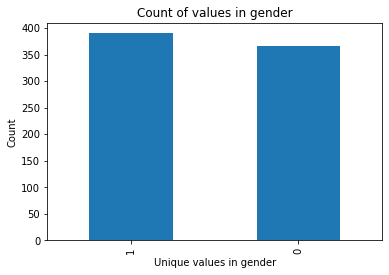

In [13]:
plot_count(X['gender'], "gender")

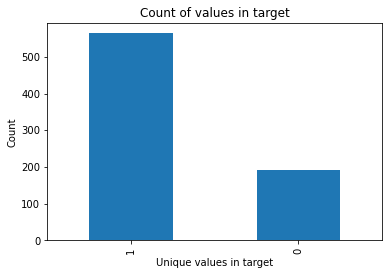

In [14]:
plot_count(y, "target")

# Feature Importance and Selection

In [15]:
xgb_model = XGBClassifier()
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
importance_scores = xgb_model.feature_importances_
sorted_idx = (-importance_scores).argsort()

In [17]:
top_features = []
cumulative_sum = 0
for i in sorted_idx:
    if cumulative_sum >= 1 or importance_scores[i] < 0.01:
        break
    top_features.append(i)
    cumulative_sum += importance_scores[i]

In [18]:
original_dataset.columns[top_features]

Index(['tqwt_entropy_shannon_dec_13', 'tqwt_medianValue_dec_31',
       'tqwt_entropy_log_dec_16', 'tqwt_entropy_log_dec_13',
       'app_entropy_log_1_coef', 'tqwt_TKEO_std_dec_12',
       'std_delta_delta_log_energy', 'tqwt_energy_dec_25',
       'tqwt_TKEO_std_dec_11', 'app_entropy_shannon_1_coef',
       'tqwt_skewnessValue_dec_25', 'tqwt_entropy_shannon_dec_33',
       'tqwt_entropy_log_dec_21', 'tqwt_entropy_shannon_dec_19',
       'app_det_TKEO_mean_4_coef', 'tqwt_maxValue_dec_11',
       'tqwt_kurtosisValue_dec_22', 'tqwt_TKEO_std_dec_19',
       'tqwt_TKEO_std_dec_9', 'tqwt_stdValue_dec_33', 'tqwt_energy_dec_8'],
      dtype='object')

### Plot the important features

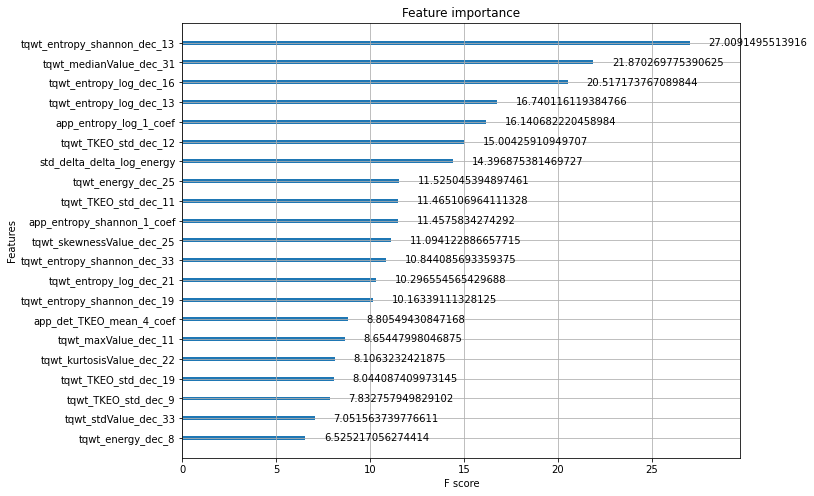

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_model, ax=ax, importance_type='gain', max_num_features=len(top_features))
plt.show()

### Create new dataframe with selected features

In [20]:
columns_to_include = ['id', 'gender'] + original_dataset.columns[top_features].to_list()

feature_selected = X[columns_to_include]
feature_selected.head()

,id,gender,tqwt_entropy_shannon_dec_13,tqwt_medianValue_dec_31,tqwt_entropy_log_dec_16,tqwt_entropy_log_dec_13,app_entropy_log_1_coef,tqwt_TKEO_std_dec_12,std_delta_delta_log_energy,tqwt_energy_dec_25,...,tqwt_entropy_shannon_dec_33,tqwt_entropy_log_dec_21,tqwt_entropy_shannon_dec_19,app_det_TKEO_mean_4_coef,tqwt_maxValue_dec_11,tqwt_kurtosisValue_dec_22,tqwt_TKEO_std_dec_19,tqwt_TKEO_std_dec_9,tqwt_stdValue_dec_33,tqwt_energy_dec_8
0,0,1,-0.634588,0.043614,-0.489374,-0.629727,-0.770060,-0.427830,0.272961,-0.752748,...,-0.046476,-0.534211,-0.017044,-0.923218,-0.872596,0.020341,-0.146282,-0.567083,-0.385544,-0.306801
1,0,1,-0.649065,-0.016383,-0.560842,-0.895187,-0.838212,-0.400936,0.037927,-0.782292,...,-0.046123,-1.005937,0.090299,-0.953336,0.035126,-0.252175,-0.283261,-0.560685,-0.376366,-0.336159
2,0,1,-0.664374,0.063933,-0.736147,-1.202074,-0.866285,-0.437091,2.798442,-0.786259,...,-0.046193,-1.332405,-0.475007,-0.971214,-1.012798,-0.078916,-0.370048,-0.610296,-0.379008,-0.314034
3,1,0,-0.249619,0.918038,0.232393,0.118957,-0.793306,-0.322060,0.182847,2.819006,...,0.041692,0.847935,-0.443920,-0.780341,0.508108,0.495640,-0.418069,-0.428860,0.132628,-0.378589
4,1,0,-0.219347,0.223247,0.311533,0.287305,-0.332018,-0.362246,-0.307043,3.038376,...,0.037122,0.877122,-0.428931,-0.208159,0.123217,0.048107,-0.509478,-0.455733,0.156217,-0.377438


# Plot the feature selected dataset

### Column Distribution

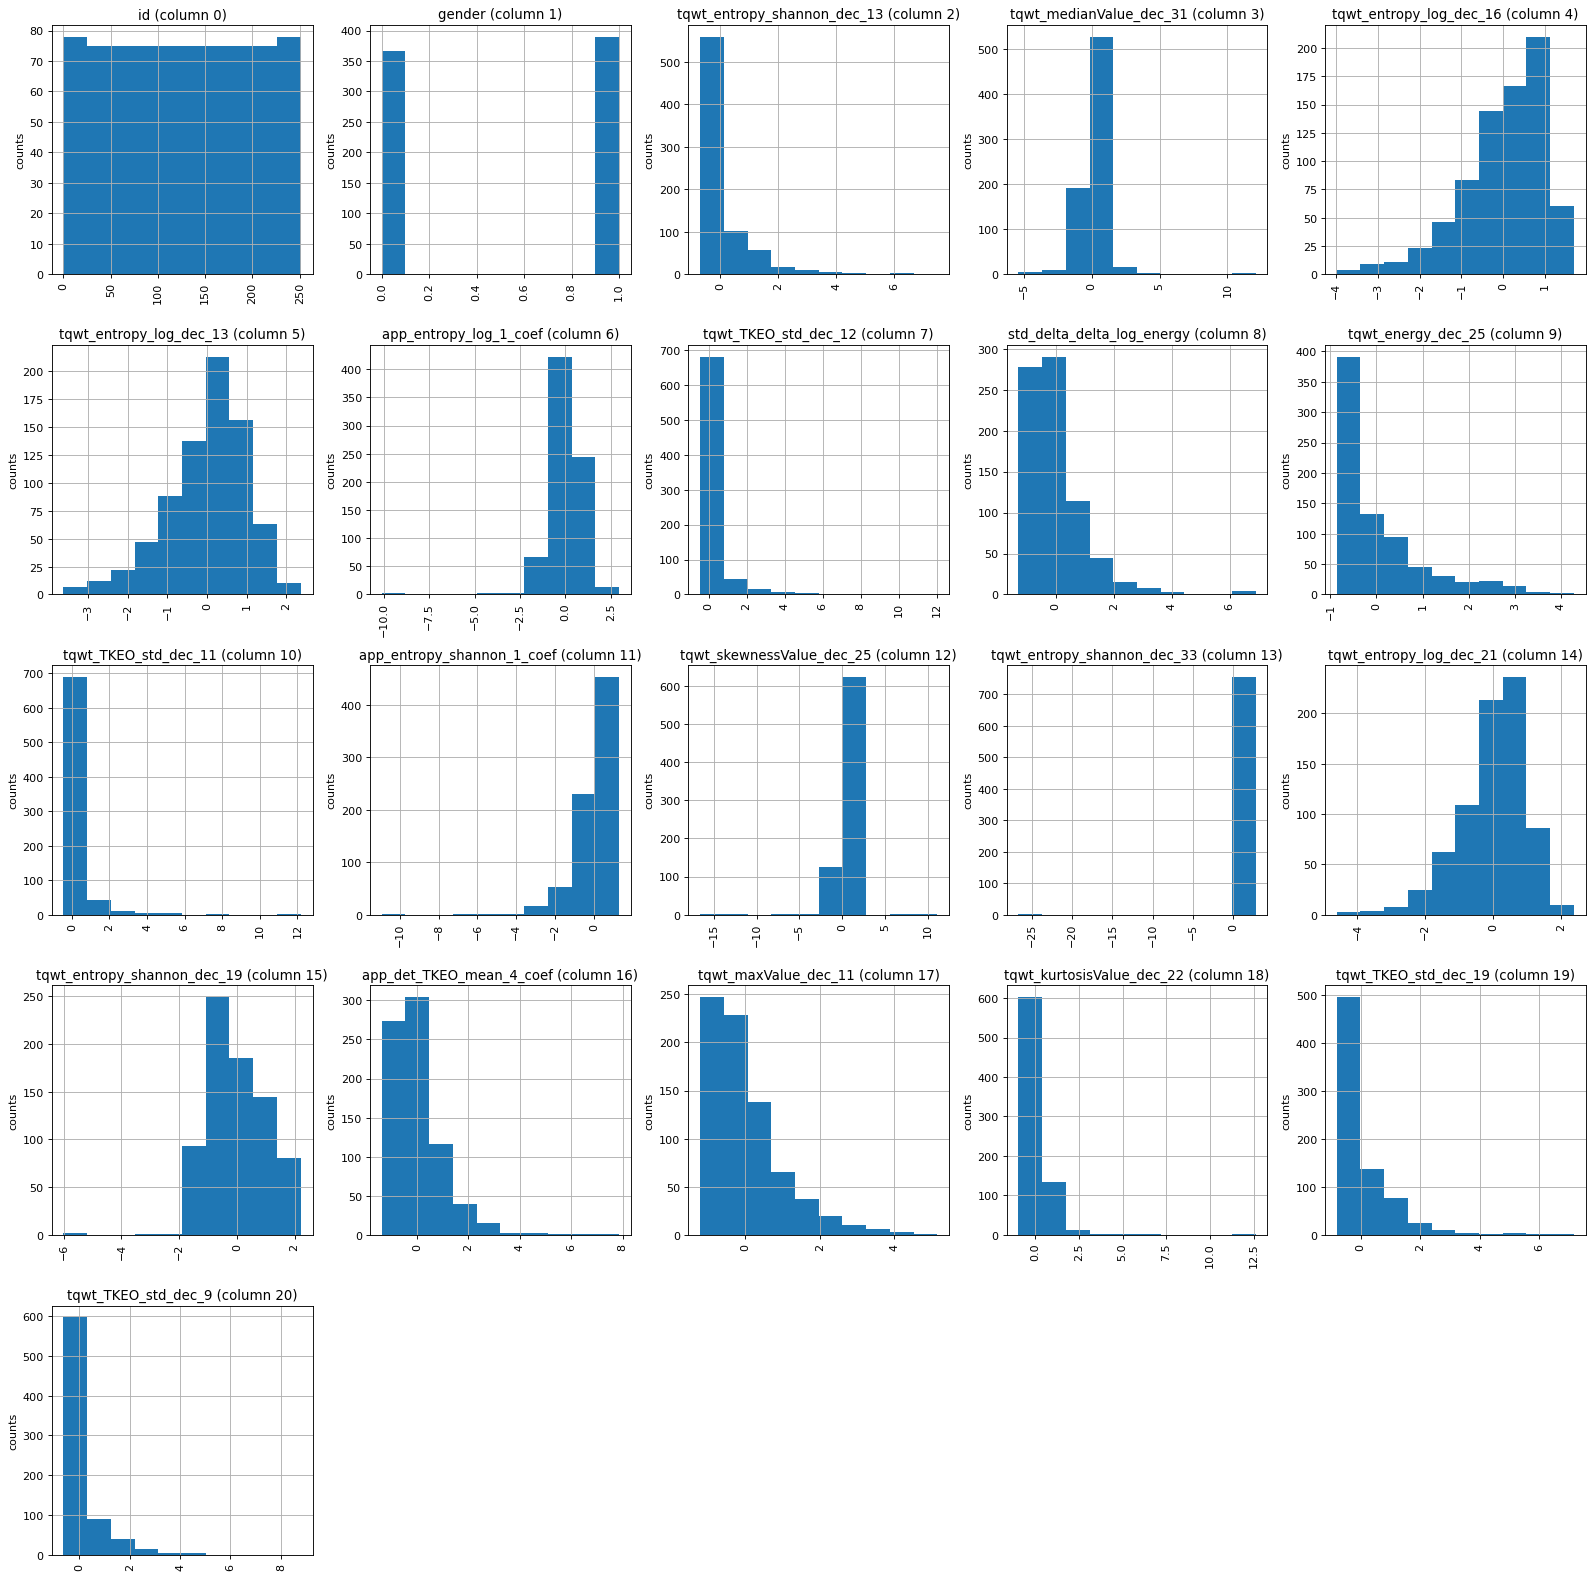

In [28]:
plotPerColumnDistribution(feature_selected, len(top_features), 5)

### Scatter Matrix

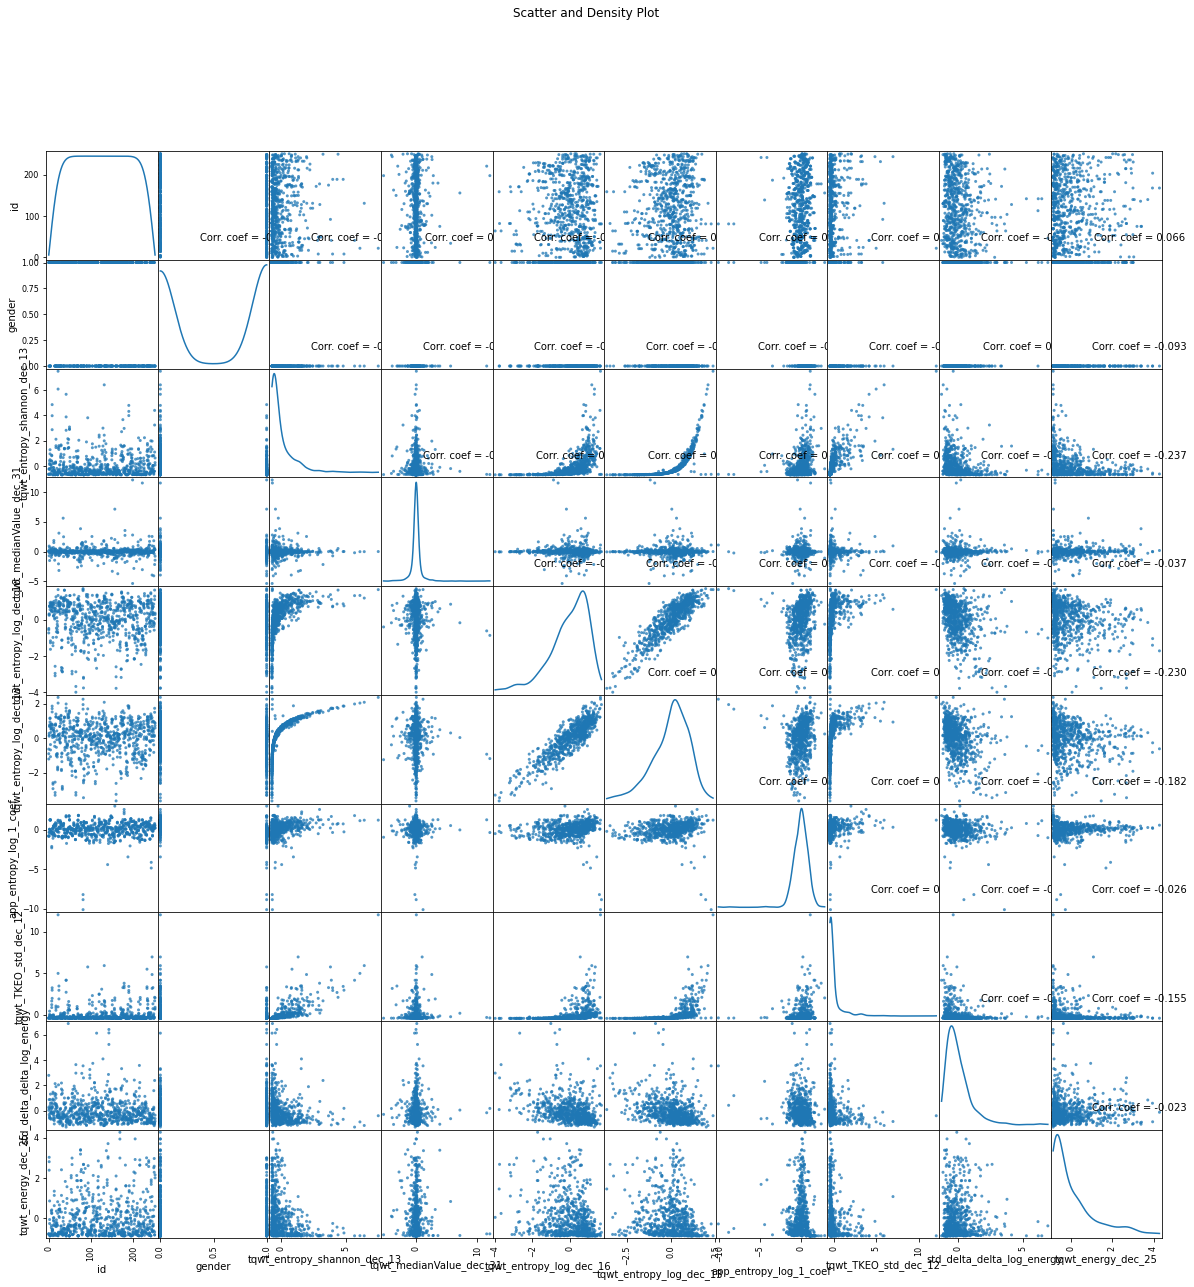

In [27]:
plotScatterMatrix(feature_selected, 20, 10)

### Correlation

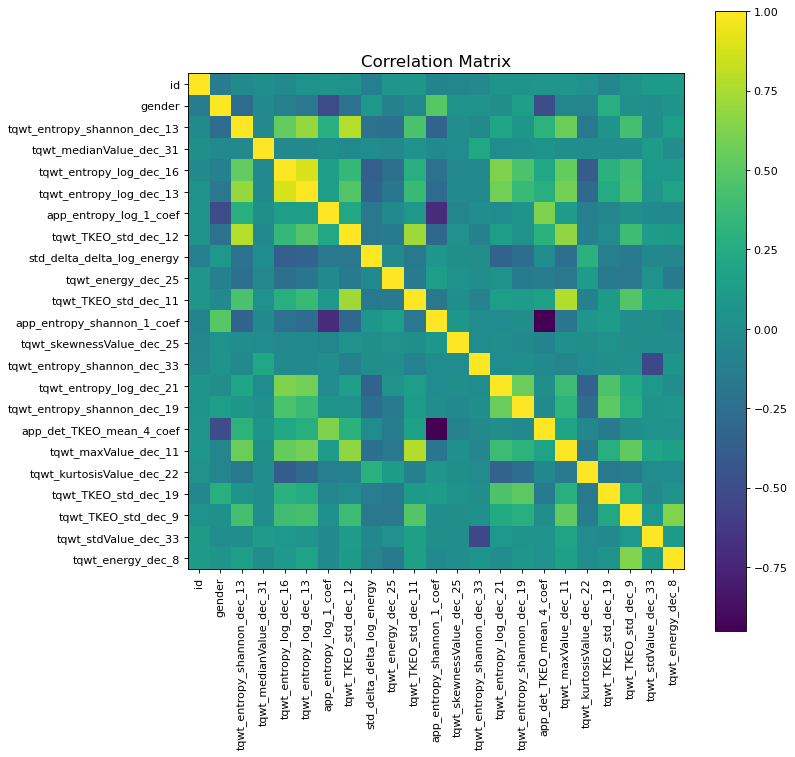

In [26]:
plotCorrelationMatrix(feature_selected, 10)

### Statistical Information

In [30]:
original_dataset[original_dataset.columns[top_features]].describe()

,tqwt_entropy_shannon_dec_13,tqwt_medianValue_dec_31,tqwt_entropy_log_dec_16,tqwt_entropy_log_dec_13,app_entropy_log_1_coef,tqwt_TKEO_std_dec_12,std_delta_delta_log_energy,tqwt_energy_dec_25,tqwt_TKEO_std_dec_11,app_entropy_shannon_1_coef,...,tqwt_entropy_shannon_dec_33,tqwt_entropy_log_dec_21,tqwt_entropy_shannon_dec_19,app_det_TKEO_mean_4_coef,tqwt_maxValue_dec_11,tqwt_kurtosisValue_dec_22,tqwt_TKEO_std_dec_19,tqwt_TKEO_std_dec_9,tqwt_stdValue_dec_33,tqwt_energy_dec_8
count,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.000000,7.560000e+02,7.560000e+02,7.560000e+02,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.000000,756.000000
mean,258.975183,0.000057,-43337.091816,-107084.104532,1176.883223,1.814443e-03,0.013872,7.934992e-02,7.995431e-04,-8.095981e+07,...,1.485654,-16195.209541,428.378667,42399.690874,0.078724,2.183111,0.077409,6.350968e-04,0.029270,0.001418
std,378.626144,0.001906,18142.715620,32817.135691,78.735779,4.105847e-03,0.009239,9.209695e-02,1.792895e-03,5.455160e+07,...,31.396880,5700.270247,325.761477,25445.952964,0.064136,0.796446,0.096772,1.016568e-03,0.068935,0.003399
min,0.031019,-0.010202,-115588.348100,-226081.848200,381.523500,3.670000e-08,0.001998,5.260000e-07,3.280000e-08,-6.764394e+08,...,-835.555600,-42454.245800,-1528.437100,7737.718300,0.000576,1.420700,0.000004,1.000000e-08,0.000603,0.000007
25%,24.999150,-0.000271,-52966.250625,-125628.536475,1138.879450,1.000375e-04,0.007817,1.203525e-02,4.857500e-05,-1.027837e+08,...,0.100890,-19240.907775,173.239200,24661.102325,0.032499,1.724150,0.015312,3.660000e-05,0.005821,0.000201
50%,111.514900,0.000005,-39916.998850,-102423.133650,1183.470150,3.994500e-04,0.011565,4.491050e-02,2.288300e-04,-6.952212e+07,...,0.337895,-15447.720500,378.120500,36719.192150,0.060889,2.002400,0.043847,2.158000e-04,0.011590,0.000567
75%,326.322325,0.000267,-29585.273325,-83585.858475,1223.352700,1.409700e-03,0.017111,1.139350e-01,7.241825e-04,-4.485262e+07,...,1.888250,-12019.246975,682.864625,53660.285125,0.106802,2.410075,0.104485,8.204300e-04,0.031062,0.001484
max,3091.513900,0.023049,-12665.407800,-29486.651600,1409.600800,5.115100e-02,0.077497,4.734700e-01,2.261100e-02,-1.047634e+07,...,89.267300,-2628.239400,1148.426000,242265.492500,0.409440,12.225600,0.769870,9.558100e-03,1.373700,0.064854


# Run Models

### Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(feature_selected, y, test_size=0.33, random_state=42)

### Logistic Regression

In [24]:
lrc = LogisticRegression(random_state=42, n_jobs=-1).fit(X_train, y_train)
lr_pred = lrc.predict(X_test)

### SGD (Linear) Classifier

In [25]:
sgdc = SGDClassifier(loss="hinge", penalty="l2", n_jobs=-1).fit(X_train, y_train)
sgdc_pred = sgdc.predict(X_test)

### K Nearest Neighbors Classifier

In [26]:
knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1).fit(X_train, y_train)
knn_pred = knn.predict(X_test)

### Decision Tree Classifier

In [27]:
dtc = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

### Random Forest Classifier

In [28]:
rfc = RandomForestClassifier(max_depth=2, random_state=42, n_jobs=-1).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

### Support Vector Machine Classifier

In [29]:
svc = SVC(gamma='auto').fit(X_train, y_train)
svc_pred6 = svc.predict(X_test)

# Compare model predictions

### Metrics: accuracy, f1 score, Recall, Precision

In [30]:
PREDICTIONS = [lr_pred, sgdc_pred, knn_pred, dtc_pred, rfc_pred, svc_pred6]

def calculate_metrics(func):
  return list(map(lambda x: func(y_test, x) * 100, PREDICTIONS))

metrics_df = pd.DataFrame({'Models': ['Logistic Regression', 'SGD CLassifier', 'K Nearest Neighbor','Decision Tree Regressor', 'Random Forest Regressor','Support Vector Machine'],
                   'Accuracy ': calculate_metrics(accuracy_score),
                   'F1 Score': calculate_metrics(f1_score),
                   'Recall': calculate_metrics(recall_score),
                   'Precision': calculate_metrics(precision_score)} )

In [31]:
metrics_df.head()

,Models,Accuracy,F1 Score,Recall,Precision
0,Logistic Regression,84.8,90.104167,95.580110,85.221675
1,SGD CLassifier,73.6,84.507042,99.447514,73.469388
2,K Nearest Neighbor,78.8,86.848635,96.685083,78.828829
3,Decision Tree Regressor,81.2,87.193460,88.397790,86.021505
4,Random Forest Regressor,83.6,89.775561,99.447514,81.818182


From the model comparison we can say that Random Forest Classifier performs the best among all the models.
Recall=1 means only one class among the two classes is getting predicted (which is not good) so we don't consider those models